In [85]:
import sys
import os
#sys.path.append(r"C:\Users\ella_\Documents\GitHub\graphs_and_topology_for_chemistry")
#sys.path.append(r"C:\Users\ella_\Documents\GitHub\icosahedron_projection")

import deepchem as dc

import tensorflow as tf
import os
import sys
import rdkit
import h5py

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
import mpl_toolkits.mplot3d
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from collections import Counter

print("TensorFlow version: " + tf.__version__)

# topology stuff
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import NumberOfPoints
from gtda.diagrams import Amplitude
from sklearn.pipeline import make_union, Pipeline

# fixc this at some point
sys.path.append(os.path.join(os.getcwd(), 'graphs_and_topology_for_chemistry'))
#sys.path.append(r"C:\Users\ella_\Documents\GitHub\icosahedron_projection")

#import projection
#from projection.molecule import Molecule
#from projection.pdbmolecule import PDBMolecule
#from projection.mol2molecule import Mol2Molecule

import graphs_and_topology_for_chemistry.helper_functions as h
#from projection.face import Face

# $UN THIS
data_dir= os.getcwd() 
results_dir=os.path.join(os.getcwd(), 'results')
test_file='qm7.csv'
data_file_name='qm7_topological_features.hdf5'
make_dataset=False # whether to recalc the dataset


print(f"DeepChem version: {dc.__version__}")

############################### settings for all experiments #################

num_repeats=10
num_epochs = 500

metric_labels=['mean_squared_error','pearson_r2_score',
               'mae_score', 'rmse']


metric1 = dc.metrics.Metric(dc.metrics.mean_squared_error)
metric2 = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric3 = dc.metrics.Metric(dc.metrics.mae_score)
metrics = [metric1, metric2, metric3]
selected_metric = 2 #which metric to use for callback

TensorFlow version: 2.7.0
DeepChem version: 2.5.0


In [86]:
hdf5_file_name='qm7_topological_features.hdf5'
fh = h5py.File(os.path.join(data_dir,hdf5_file_name), 'r+')
num_of_rows, num_of_molecules = h.basic_info_hdf5_dataset(fh, label='molID')

num_of_ rows is:	6838
num_of_molecules is:	 128
MolID: count
Counter({127: 6711, 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1})


In [87]:
# list of topological features, this is what we learn from
feature_name_list = ['pers_S_1', 'pers_S_2', 'pers_S_3',
                    'no_p_1', 'no_p_2', 'no_p_3',
                    'bottle_1', 'bottle_2', 'bottle_3',
                    'wasser_1', 'wasser_2', 'wasser_3',
                    'landsc_1', 'landsc_2', 'landsc_3',
                    'pers_img_1', 'pers_img_2', 'pers_img_3']

# alternative features
PCA_list = ['PCA_1', 'PCA_2', 'PCA_3',
           'PCA_4', 'PCA_5', 'PCA_6',
           'PCA_7', 'PCA_8', 'PCA_9',
           'PCA_10', 'PCA_11', 'PCA_12',
           'PCA_13', 'PCA_14', 'PCA_15',
           'PCA_16', 'PCA_17', 'PCA_18']

# tasks to do
tasks = ['u0_atom']

In [88]:
## loading data from the hdf5 file
# takes data from the hdf5 file and puts it into a variable called X_data
X_data = h.load_all_hdf5(
    fh,
    num_of_rows, 
    column_headers=feature_name_list)

PCA_X_data = h.load_all_hdf5(
    fh,
    num_of_rows, 
    column_headers=PCA_list)

y_data = h.load_all_hdf5(
    fh,
    num_of_rows, 
    column_headers=tasks)

# makes a list of SMILES strings
SMILES_list = np.array(fh['SMILES'])

# this makes the actual topological datasets
topol_dataset = dc.data.DiskDataset.from_numpy(
    X_data, 
    y_data, 
    ids=SMILES_list)

pca_dataset = dc.data.DiskDataset.from_numpy(
    PCA_X_data, 
    y_data, 
    ids=SMILES_list)

# setting up the splitters for the task
Splitter_Object = dc.splits.SingletaskStratifiedSplitter()






Text(0, 0.5, 'No.')

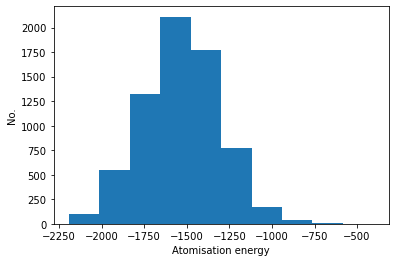

In [89]:
plt.hist(y_data)
plt.xlabel('Atomisation energy')
plt.ylabel("No.")

In [96]:
# This loads the data without shuffling or splitting
tasks, datasets, transformers = dc.molnet.load_qm7(
    shard_size=2000,
    featurizer=dc.feat.MACCSKeysFingerprint(),
    #featurizer=h.My_Dummy_Featurizer(None),
    splitter=None)

# This loads the data without shuffling or splitting
#tasks, datasets, transformers = dc.molnet.load_qm7(
#    shard_size=2000,
#    featurizer=dc.feat.CoulombMatrix
#    (max_atoms=23),
#    #featurizer=h.My_Dummy_Featurizer(None),
#    splitter=None)

In [97]:
datasets[0].X[3].flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [93]:
smiles_list_2

array([b'[H].[H].[H][C][H]', b'[H]C([H])([H])C([H])([H])[H]',
       b'[H]C([H])=C([H])[H]', ...,
       b'[H]/C(=C(\\C#N)C([H])([H])C([H])([H])[H])C([H])([H])[H]',
       b'[H]C([H])=C1C([H])([H])C([H])=C([H])[C@]1([H])C([H])([H])[H]',
       b'[H]C1([H])C([H])([H])C([H])([H])C2(C1([H])[H])C([H])([H])C2([H])[H]'],
      dtype=object)

In [95]:
smiles_list_1

array(['[H].[H].[H][C][H]', '[H]C([H])([H])C([H])([H])[H]',
       '[H]C([H])=C([H])[H]', ...,
       '[H]/C(=C(\\C#N)C([H])([H])C([H])([H])[H])C([H])([H])[H]',
       '[H]C([H])=C1C([H])([H])C([H])=C([H])[C@]1([H])C([H])([H])[H]',
       '[H]C1([H])C([H])([H])C([H])([H])C2(C1([H])[H])C([H])([H])C2([H])[H]'],
      dtype=object)

In [91]:
# deepchem features
dataset_1 = datasets[0].X
smiles_list_1=datasets[0].ids

# tdaf features
dataset_2 = X_data
dataset_2_y = y_data
smiles_list_2=SMILES_list


def join_featurisation_vectors(
    dataset_1,
    dataset_2,
    dataset_2_y,
    smiles_list_1=[],
    smiles_list_2=[]):
    """sticks together two featurisation vectors
    dataset_1 = lefthand dataset
    dataset_2 = righthand_dataset
    smiles_list_1 = lefthand dataset
    smiles_list_2 = righthand dataset
    N.B. expects datasets to a list of lists or 2D nparray 
    i.e. x samples by y features
 """
    new_X_data = []
    if len(dataset_2) == len(dataset_1):
        #  datasets have the same number
        for i in range(len(dataset_2)):
            # this grabs the deepchem features and copies it
            # remove the flatten
            deepchem_feature = [float(x) for x in dataset_1[i]]
    #        deepchem_feature = [float(x) for x in dataset_1[i]]
            # this grabs the tdaf and copies it
            tdaf_feature = [float(x) for x in dataset_2[i]]
            # this sticks them together
            new_X_data.append(np.array(deepchem_feature + tdaf_feature))
    else:
        # doing smiles comparison
        print('Datasets are different sizes')
        print('Using smiles strings to sort this out')
        # frist check change type from bytes
        if type(smiles_list_1[3]) == bytes:
            smiles_list_1 = [i.decode() for i in smiles_list_1]
        if type(smiles_list_2[3]) == bytes:
            smiles_list_2 = [i.decode() for i in smiles_list_2]  
            
        print(smiles_list_1[3])
        print(smiles_list_2[3])
        print(smiles_list_1[3]==smiles_list_2[3])
        new_X_data = []
        new_y_data = []
        new_smiles_list=[]
        for i in range(len(dataset_2)):
            # this grabs the deepchem features and copies it
            # remove the flatten
            for i_1 in range(len(dataset_1)):
                    if smiles_list_1[i_1]==smiles_list_2[i]:
                        #i_new=smiles_list_1.index(smiles_list_2[i])
                        #print(smiles_list_2[i])
                        #print(smiles_list_1[i_1])
                        deepchem_feature = [float(x) for x in dataset_1[i_1]]
                        tdaf_feature = [float(x) for x in dataset_2[i]]
                        new_X_data.append(np.array(deepchem_feature + tdaf_feature))  
                        new_y_data.append(np.array(dataset_2_y[i]))
                        new_smiles_list.append(smiles_list_2[i])
              
    
    return new_X_data, new_y_data, new_smiles_list

new_X_data,new_y_data,new_smiles_list = join_featurisation_vectors(
    dataset_1,
    dataset_2,
    dataset_2_y,
    smiles_list_1,
    smiles_list_2
    )
combined_dataset = dc.data.DiskDataset.from_numpy(
    new_X_data, 
    new_y_data, 
    ids=new_smiles_list)

UnboundLocalError: local variable 'new_y_data' referenced before assignment

In [141]:
# this makes the actual topological datasets
combined_dataset = dc.data.DiskDataset.from_numpy(
    new_X_data, 
    y_data, 
    ids=SMILES_list)

C:\Users\ella_\.conda\envs\tdaf-tf2p7h2\lib\site-packages\numpy\lib\format.py:363: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


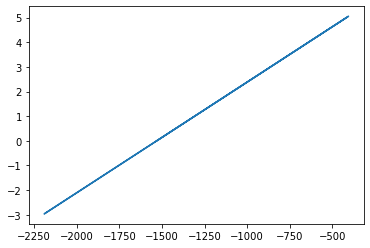

In [142]:
plt.plot(topol_dataset.y, datasets[0].y)

# fixing bbbp

In [109]:
# $UN THIS
data_dir= os.getcwd() 
results_dir=os.path.join(os.getcwd(), 'results')
test_file='bbbp.csv'
data_file_name='bbbp_topological_features.hdf5'
make_dataset=False # whether to recalc the dataset

hdf5_file_name='bbbp_topological_features.hdf5'
fh = h5py.File(os.path.join(data_dir,hdf5_file_name), 'r+')
num_of_rows, num_of_molecules = h.basic_info_hdf5_dataset(fh, label='molID')

# list of topological features, this is what we learn from
feature_name_list = ['pers_S_1', 'pers_S_2', 'pers_S_3',
                    'no_p_1', 'no_p_2', 'no_p_3',
                    'bottle_1', 'bottle_2', 'bottle_3',
                    'wasser_1', 'wasser_2', 'wasser_3',
                    'landsc_1', 'landsc_2', 'landsc_3',
                    'pers_img_1', 'pers_img_2', 'pers_img_3']

# alternative features
PCA_list = ['PCA_1', 'PCA_2', 'PCA_3',
           'PCA_4', 'PCA_5', 'PCA_6',
           'PCA_7', 'PCA_8', 'PCA_9',
           'PCA_10', 'PCA_11', 'PCA_12',
           'PCA_13', 'PCA_14', 'PCA_15',
           'PCA_16', 'PCA_17', 'PCA_18']

# tasks to do
tasks = ['p_np']

## loading data from the hdf5 file
# takes data from the hdf5 file and puts it into a variable called X_data
X_data = h.load_all_hdf5(
    fh,
    num_of_rows, 
    column_headers=feature_name_list)

PCA_X_data = h.load_all_hdf5(
    fh,
    num_of_rows, 
    column_headers=PCA_list)

y_data = h.load_all_hdf5(
    fh,
    num_of_rows, 
    column_headers=tasks)

# makes a list of SMILES strings
SMILES_list = np.array(fh['SMILES'])

# this makes the actual topological datasets
topol_dataset = dc.data.DiskDataset.from_numpy(
    X_data, 
    y_data, 
    ids=SMILES_list)

pca_dataset = dc.data.DiskDataset.from_numpy(
    PCA_X_data, 
    y_data, 
    ids=SMILES_list)


# This loads the data without shuffling or splitting
tasks, datasets, transformers = dc.molnet.load_bbbp(
    shard_size=2000,
    featurizer=dc.feat.MACCSKeysFingerprint(),
    #featurizer=h.My_Dummy_Featurizer(None),
    splitter=None)

num_of_ rows is:	2036
num_of_molecules is:	 2036
num_of_augments is:	1


In [112]:
# This is the splitter we're using, look at the DeepChem 
# paper to see which one you should use
Splitter_Object = dc.splits.SingletaskStratifiedSplitter()
# This shuffles the data and makes 
# the train, test and validate datasets from
# the topologcal data
train_dataset, valid_dataset, test_dataset = Splitter_Object.train_valid_test_split(
    dataset=topol_dataset,
    frac_train=0.8,
    frac_valid=0.1,
    frac_test=0.1)
# this builds the datasets for training

print(f"Training with {len(train_dataset.y)} points")
print(f"Validation with {len(valid_dataset.y)} points")
print(f"Testing with {len(test_dataset.y)} points")
print(f"Total dataset size: {len(train_dataset.y) + len(valid_dataset.y) + len(test_dataset.y)}")

# transforms datasets wooo
#train_dataset = h.do_transform(transformers_tf, train_dataset)
#valid_dataset = h.do_transform(transformers_tf, valid_dataset)
#test_dataset = h.do_transform(transformers_tf, test_dataset)
datasets = [train_dataset, valid_dataset, test_dataset]

Training with 1624 points
Validation with 203 points
Testing with 203 points
Total dataset size: 2030


In [110]:
# deepchem features
dataset_1 = datasets[0].X
smiles_list_1=datasets[0].ids

# tdaf features
dataset_2 = X_data
dataset_2_y = y_data
smiles_list_2=SMILES_list


def join_featurisation_vectors(
    dataset_1,
    dataset_2,
    dataset_2_y,
    smiles_list_1=[],
    smiles_list_2=[]):
    """sticks together two featurisation vectors
    dataset_1 = lefthand dataset
    dataset_2 = righthand_dataset
    smiles_list_1 = lefthand dataset
    smiles_list_2 = righthand dataset
    N.B. expects datasets to a list of lists or 2D nparray 
    i.e. x samples by y features
 """
    new_X_data = []
    if len(dataset_2) == len(dataset_1):
        #  datasets have the same number
        for i in range(len(dataset_2)):
            # this grabs the deepchem features and copies it
            # remove the flatten
            deepchem_feature = [float(x) for x in dataset_1[i]]
    #        deepchem_feature = [float(x) for x in dataset_1[i]]
            # this grabs the tdaf and copies it
            tdaf_feature = [float(x) for x in dataset_2[i]]
            # this sticks them together
            new_X_data.append(np.array(deepchem_feature + tdaf_feature))
    else:
        # doing smiles comparison
        print('Datasets are different sizes')
        print('Using smiles strings to sort this out')
        # frist check change type from bytes
        if type(smiles_list_1[3]) == bytes:
            smiles_list_1 = [i.decode() for i in smiles_list_1]
        if type(smiles_list_2[3]) == bytes:
            smiles_list_2 = [i.decode() for i in smiles_list_2]  
            
        print(smiles_list_1[3])
        print(smiles_list_2[3])
        print(smiles_list_1[3]==smiles_list_2[3])
        new_X_data = []
        new_y_data = []
        new_smiles_list=[]
        for i in range(len(dataset_2)):
            # this grabs the deepchem features and copies it
            # remove the flatten
            for i_1 in range(len(dataset_1)):
                    if smiles_list_1[i_1]==smiles_list_2[i]:
                        #i_new=smiles_list_1.index(smiles_list_2[i])
                        #print(smiles_list_2[i])
                        #print(smiles_list_1[i_1])
                        deepchem_feature = [float(x) for x in dataset_1[i_1]]
                        tdaf_feature = [float(x) for x in dataset_2[i]]
                        new_X_data.append(np.array(deepchem_feature + tdaf_feature))  
                        new_y_data.append(dataset_2_y[i])
                        new_smiles_list.append(smiles_list_2[i])
              
    
    return new_X_data, new_y_data, new_smiles_list

new_X_data,new_y_data,new_smiles_list = join_featurisation_vectors(
    dataset_1,
    dataset_2,
    dataset_2_y,
    smiles_list_1,
    smiles_list_2
    )
combined_dataset = dc.data.DiskDataset.from_numpy(
    new_X_data, 
    new_y_data, 
    ids=new_smiles_list)

Datasets are different sizes
Using smiles strings to sort this out
C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
True


In [111]:
combined_dataset = dc.data.DiskDataset.from_numpy(
    new_X_data, 
    new_y_data, 
    ids=new_smiles_list)

In [72]:
combined_dataset=joint_dataset

In [59]:
# doing a transform on the data to make it easier for hte NN
# normalises both y and x
## for use with topol_dataset
transformers_tf = [
    dc.trans.NormalizationTransformer(
        transform_X=True, 
        dataset=combined_dataset),
    dc.trans.NormalizationTransformer(
        transform_y=True, 
        dataset=combined_dataset)]
# normalises only y (as doing a PCA is a type of normalisation)
# for use with pca_dataset
transformers_pca = [
    dc.trans.NormalizationTransformer(
        transform_y=True, 
        dataset=pca_dataset)]

In [106]:
# This is the splitter we're using, look at the DeepChem 
# paper to see which one you should use
Splitter_Object = dc.splits.SingletaskStratifiedSplitter()
# This shuffles the data and makes 
# the train, test and validate datasets from
# the topologcal data
train_dataset, valid_dataset, test_dataset = Splitter_Object.train_valid_test_split(
    dataset=combined_dataset,
    frac_train=0.8,
    frac_valid=0.1,
    frac_test=0.1)
# this builds the datasets for training

print(f"Training with {len(train_dataset.y)} points")
print(f"Validation with {len(valid_dataset.y)} points")
print(f"Testing with {len(test_dataset.y)} points")
print(f"Total dataset size: {len(train_dataset.y) + len(valid_dataset.y) + len(test_dataset.y)}")

# transforms datasets wooo
#train_dataset = h.do_transform(transformers_tf, train_dataset)
#valid_dataset = h.do_transform(transformers_tf, valid_dataset)
#test_dataset = h.do_transform(transformers_tf, test_dataset)
datasets = [train_dataset, valid_dataset, test_dataset]

Training with 1624 points
Validation with 203 points
Testing with 203 points
Total dataset size: 2030


In [107]:
new_y_data

[array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array

In [77]:
patience = 3 # try for 15 more epochs if you think it's trained

### actual model here
model = dc.models.MultitaskRegressor(
    n_tasks=len(tasks), # size of y
    n_features=len(train_dataset.X[3]), # size of input to model
    layer_sizes=[1000,500],
    dropouts=0.2,
    #learning_rate=0.001,
    residual=True)

## this does the early stopping ##
callback = dc.models.ValidationCallback(
    valid_dataset, # which dataset to use for valdiation
    patience, # how long to wait if the program thinks the model is trained
    metrics[selected_metric]) # metric to use to do the validation

In [78]:
%%time
# fit da model
model.fit(train_dataset, nb_epoch=num_epochs, callbacks=callback)

Step 3 validation: mae_score=1.62057
Step 6 validation: mae_score=2.55766
Step 9 validation: mae_score=0.494902
Step 12 validation: mae_score=0.722176
Step 15 validation: mae_score=0.85705
Step 18 validation: mae_score=0.70874
Step 21 validation: mae_score=0.445681
Step 24 validation: mae_score=0.268769
Step 27 validation: mae_score=0.361329
Step 30 validation: mae_score=0.403385
Step 33 validation: mae_score=0.417206
Step 36 validation: mae_score=0.416284
Step 39 validation: mae_score=0.406784
Step 42 validation: mae_score=0.393394
Step 45 validation: mae_score=0.383966
Step 48 validation: mae_score=0.380492
Step 51 validation: mae_score=0.374728
Step 54 validation: mae_score=0.368337
Step 57 validation: mae_score=0.362612
Step 60 validation: mae_score=0.356372
Step 63 validation: mae_score=0.351968
Step 66 validation: mae_score=0.34859
Step 69 validation: mae_score=0.337949
Step 72 validation: mae_score=0.331614
Step 75 validation: mae_score=0.332336
Step 78 validation: mae_score=0.3

Step 585 validation: mae_score=0.243195
Step 588 validation: mae_score=0.245242
Step 591 validation: mae_score=0.269539
Step 594 validation: mae_score=0.294688
Step 597 validation: mae_score=0.271466
Step 600 validation: mae_score=0.258073
Step 603 validation: mae_score=0.259228
Step 606 validation: mae_score=0.271289
Step 609 validation: mae_score=0.277667
Step 612 validation: mae_score=0.256014
Step 615 validation: mae_score=0.246669
Step 618 validation: mae_score=0.249877
Step 621 validation: mae_score=0.277545
Step 624 validation: mae_score=0.257791
Step 627 validation: mae_score=0.245307
Step 630 validation: mae_score=0.255462
Step 633 validation: mae_score=0.259694
Step 636 validation: mae_score=0.25621
Step 639 validation: mae_score=0.261621
Step 642 validation: mae_score=0.267159
Step 645 validation: mae_score=0.266196
Step 648 validation: mae_score=0.253073
Step 651 validation: mae_score=0.242368
Step 654 validation: mae_score=0.249863
Step 657 validation: mae_score=0.25738
St

Step 1197 validation: mae_score=0.282671
Step 1200 validation: mae_score=0.234595
Step 1203 validation: mae_score=0.237414
Step 1206 validation: mae_score=0.271557
Step 1209 validation: mae_score=0.268936
Step 1212 validation: mae_score=0.2491
Step 1215 validation: mae_score=0.249306
Step 1218 validation: mae_score=0.243343
Step 1221 validation: mae_score=0.236153
Step 1224 validation: mae_score=0.252007
Step 1227 validation: mae_score=0.255204
Step 1230 validation: mae_score=0.253429
Step 1233 validation: mae_score=0.279401
Step 1236 validation: mae_score=0.240673
Step 1239 validation: mae_score=0.225733
Step 1242 validation: mae_score=0.240513
Step 1245 validation: mae_score=0.272501
Step 1248 validation: mae_score=0.252461
Step 1251 validation: mae_score=0.242145
Step 1254 validation: mae_score=0.263483
Step 1257 validation: mae_score=0.244719
Step 1260 validation: mae_score=0.226184
Step 1263 validation: mae_score=0.238286
Step 1266 validation: mae_score=0.240566
Step 1269 validati

Step 1803 validation: mae_score=0.233598
Step 1806 validation: mae_score=0.246373
Step 1809 validation: mae_score=0.260554
Step 1812 validation: mae_score=0.223154
Step 1815 validation: mae_score=0.227605
Step 1818 validation: mae_score=0.279556
Step 1821 validation: mae_score=0.240481
Step 1824 validation: mae_score=0.212419
Step 1827 validation: mae_score=0.258874
Step 1830 validation: mae_score=0.251882
Step 1833 validation: mae_score=0.2189
Step 1836 validation: mae_score=0.239376
Step 1839 validation: mae_score=0.257315
Step 1842 validation: mae_score=0.235577
Step 1845 validation: mae_score=0.22771
Step 1848 validation: mae_score=0.242695
Step 1851 validation: mae_score=0.232336
Step 1854 validation: mae_score=0.229212
Step 1857 validation: mae_score=0.2532
Step 1860 validation: mae_score=0.258147
Step 1863 validation: mae_score=0.226414
Step 1866 validation: mae_score=0.2216
Step 1869 validation: mae_score=0.244221
Step 1872 validation: mae_score=0.24263
Step 1875 validation: ma

Step 2412 validation: mae_score=0.22813
Step 2415 validation: mae_score=0.255228
Step 2418 validation: mae_score=0.224798
Step 2421 validation: mae_score=0.222453
Step 2424 validation: mae_score=0.251977
Step 2427 validation: mae_score=0.214231
Step 2430 validation: mae_score=0.236901
Step 2433 validation: mae_score=0.271709
Step 2436 validation: mae_score=0.234109
Step 2439 validation: mae_score=0.246757
Step 2442 validation: mae_score=0.246686
Step 2445 validation: mae_score=0.220199
Step 2448 validation: mae_score=0.227028
Step 2451 validation: mae_score=0.242914
Step 2454 validation: mae_score=0.233723
Step 2457 validation: mae_score=0.238606
Step 2460 validation: mae_score=0.226245
Step 2463 validation: mae_score=0.227522
Step 2466 validation: mae_score=0.240758
Step 2469 validation: mae_score=0.21741
Step 2472 validation: mae_score=0.23249
Step 2475 validation: mae_score=0.244299
Step 2478 validation: mae_score=0.22645
Step 2481 validation: mae_score=0.233739
Step 2484 validation

Step 3033 validation: mae_score=0.227659
Step 3036 validation: mae_score=0.220973
Step 3039 validation: mae_score=0.247495
Step 3042 validation: mae_score=0.230535
Step 3045 validation: mae_score=0.223911
Step 3048 validation: mae_score=0.222473
Step 3051 validation: mae_score=0.223846
Step 3054 validation: mae_score=0.21549
Step 3057 validation: mae_score=0.222776
Step 3060 validation: mae_score=0.220364
Step 3063 validation: mae_score=0.223751
Step 3066 validation: mae_score=0.235224
Step 3069 validation: mae_score=0.224178
Step 3072 validation: mae_score=0.225888
Step 3075 validation: mae_score=0.239394
Step 3078 validation: mae_score=0.234993
Step 3081 validation: mae_score=0.228914
Step 3084 validation: mae_score=0.22919
Step 3087 validation: mae_score=0.231317
Step 3090 validation: mae_score=0.240846
Step 3093 validation: mae_score=0.2206
Step 3096 validation: mae_score=0.221888
Step 3099 validation: mae_score=0.224323
Step 3102 validation: mae_score=0.222403
Step 3105 validation

Step 3645 validation: mae_score=0.22366
Step 3648 validation: mae_score=0.22905
Step 3651 validation: mae_score=0.223216
Step 3654 validation: mae_score=0.223388
Step 3657 validation: mae_score=0.23373
Step 3660 validation: mae_score=0.217463
Step 3663 validation: mae_score=0.217919
Step 3666 validation: mae_score=0.238113
Step 3669 validation: mae_score=0.225914
Step 3672 validation: mae_score=0.226379
Step 3675 validation: mae_score=0.231718
Step 3678 validation: mae_score=0.225123
Step 3681 validation: mae_score=0.227099
Step 3684 validation: mae_score=0.225223
Step 3687 validation: mae_score=0.238084
Step 3690 validation: mae_score=0.218423
Step 3693 validation: mae_score=0.214119
Step 3696 validation: mae_score=0.227641
Step 3699 validation: mae_score=0.227765
Step 3702 validation: mae_score=0.22303
Step 3705 validation: mae_score=0.232847
Step 3708 validation: mae_score=0.235472
Step 3711 validation: mae_score=0.22134
Step 3714 validation: mae_score=0.217818
Step 3717 validation:

Step 4248 validation: mae_score=0.236037
Step 4251 validation: mae_score=0.239747
Step 4254 validation: mae_score=0.225098
Step 4257 validation: mae_score=0.227978
Step 4260 validation: mae_score=0.23136
Step 4263 validation: mae_score=0.223728
Step 4266 validation: mae_score=0.218713
Step 4269 validation: mae_score=0.217948
Step 4272 validation: mae_score=0.213979
Step 4275 validation: mae_score=0.214466
Step 4278 validation: mae_score=0.221287
Step 4281 validation: mae_score=0.245724
Step 4284 validation: mae_score=0.230038
Step 4287 validation: mae_score=0.218647
Step 4290 validation: mae_score=0.230322
Step 4293 validation: mae_score=0.232982
Step 4296 validation: mae_score=0.226006
Step 4299 validation: mae_score=0.230475
Step 4302 validation: mae_score=0.231467
Step 4305 validation: mae_score=0.232135
Step 4308 validation: mae_score=0.224559
Step 4311 validation: mae_score=0.237147
Step 4314 validation: mae_score=0.239637
Step 4317 validation: mae_score=0.225992
Step 4320 validat

Step 4854 validation: mae_score=0.223612
Step 4857 validation: mae_score=0.226421
Step 4860 validation: mae_score=0.213556
Step 4863 validation: mae_score=0.217926
Step 4866 validation: mae_score=0.223738
Step 4869 validation: mae_score=0.223525
Step 4872 validation: mae_score=0.224382
Step 4875 validation: mae_score=0.222304
Step 4878 validation: mae_score=0.212551
Step 4881 validation: mae_score=0.211717
Step 4884 validation: mae_score=0.219012
Step 4887 validation: mae_score=0.217996
Step 4890 validation: mae_score=0.224869
Step 4893 validation: mae_score=0.216351
Step 4896 validation: mae_score=0.211291
Step 4899 validation: mae_score=0.219036
Step 4902 validation: mae_score=0.225095
Step 4905 validation: mae_score=0.228187
Step 4908 validation: mae_score=0.223445
Step 4911 validation: mae_score=0.212138
Step 4914 validation: mae_score=0.207991
Step 4917 validation: mae_score=0.222945
Step 4920 validation: mae_score=0.208433
Step 4923 validation: mae_score=0.224531
Step 4926 valida

Step 5472 validation: mae_score=0.21668
Step 5475 validation: mae_score=0.225054
Step 5478 validation: mae_score=0.22774
Step 5481 validation: mae_score=0.210717
Step 5484 validation: mae_score=0.217212
Step 5487 validation: mae_score=0.226536
Step 5490 validation: mae_score=0.217824
Step 5493 validation: mae_score=0.224681
Step 5496 validation: mae_score=0.220924
Step 5499 validation: mae_score=0.213486
Step 5502 validation: mae_score=0.208493
Step 5505 validation: mae_score=0.21773
Step 5508 validation: mae_score=0.213057
Step 5511 validation: mae_score=0.223039
Step 5514 validation: mae_score=0.21194
Step 5517 validation: mae_score=0.212797
Step 5520 validation: mae_score=0.217127
Step 5523 validation: mae_score=0.229552
Step 5526 validation: mae_score=0.219525
Step 5529 validation: mae_score=0.241119
Step 5532 validation: mae_score=0.224079
Step 5535 validation: mae_score=0.219471
Step 5538 validation: mae_score=0.238235
Step 5541 validation: mae_score=0.210627
Step 5544 validation

Step 6087 validation: mae_score=0.234043
Step 6090 validation: mae_score=0.225324
Step 6093 validation: mae_score=0.216323
Step 6096 validation: mae_score=0.215596
Step 6099 validation: mae_score=0.204869
Step 6102 validation: mae_score=0.2075
Step 6105 validation: mae_score=0.216016
Step 6108 validation: mae_score=0.219509
Step 6111 validation: mae_score=0.212705
Step 6114 validation: mae_score=0.211703
Step 6117 validation: mae_score=0.198648
Step 6120 validation: mae_score=0.204019
Step 6123 validation: mae_score=0.207396
Step 6126 validation: mae_score=0.199603
Step 6129 validation: mae_score=0.205072
Step 6132 validation: mae_score=0.223334
Step 6135 validation: mae_score=0.225791
Step 6138 validation: mae_score=0.212906
Step 6141 validation: mae_score=0.213943
Step 6144 validation: mae_score=0.218317
Step 6147 validation: mae_score=0.212309
Step 6150 validation: mae_score=0.204574
Step 6153 validation: mae_score=0.208223
Step 6156 validation: mae_score=0.209401
Step 6159 validati

Step 6699 validation: mae_score=0.200064
Step 6702 validation: mae_score=0.204393
Step 6705 validation: mae_score=0.211563
Step 6708 validation: mae_score=0.211592
Step 6711 validation: mae_score=0.215028
Step 6714 validation: mae_score=0.221958
Step 6717 validation: mae_score=0.217347
Step 6720 validation: mae_score=0.226061
Step 6723 validation: mae_score=0.221621
Step 6726 validation: mae_score=0.207537
Step 6729 validation: mae_score=0.213158
Step 6732 validation: mae_score=0.234577
Step 6735 validation: mae_score=0.220447
Step 6738 validation: mae_score=0.215173
Step 6741 validation: mae_score=0.216492
Step 6744 validation: mae_score=0.208708
Step 6747 validation: mae_score=0.208564
Step 6750 validation: mae_score=0.222884
Step 6753 validation: mae_score=0.207485
Step 6756 validation: mae_score=0.208232
Step 6759 validation: mae_score=0.216022
Step 6762 validation: mae_score=0.218959
Step 6765 validation: mae_score=0.219685
Step 6768 validation: mae_score=0.209008
Step 6771 valida

KeyboardInterrupt: 

In [65]:
# little function to calc metrics on this data
out=h.get_them_metrics(
    model,
    datasets,
    metrics,
    metric_labels,
    transformers=transformers_tf)

pd_out = pd.DataFrame([out], 
        columns=['tr_mse', 'tr_r2', 'tr_mae', 'tr_rmse', # training metrics
        'val_mse', 'val_r2', 'val_mae', 'val_rmse', # valdiation metrics
        'te_mse', 'te_r2', 'te_mae', 'te_rmse']) # testing metrics
pd_out

,tr_mse,tr_r2,tr_mae,tr_rmse,val_mse,val_r2,val_mae,val_rmse,te_mse,te_r2,te_mae,te_rmse
0,0.009318,0.951397,0.040878,0.096528,0.138653,0.291353,0.199119,0.372361,0.116042,0.389178,0.184053,0.34065


## Using tf with NO DEEPCHEM

In [127]:
combined_dataset.X[7]

array([63.2970758 , 24.3690392 , 24.36830369,  0.46850576,  0.28909361,
        0.22151853,  0.2214124 ,  0.1697016 ,  0.169665  ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.91842496, -1.        ,
       -1.        ,  8.        ,  0.        ,  0.        ,  0.75130147,
        0.        ,  0.        ,  1.70020294,  0.        ,  0.        ,
        0.53168398,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [97]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.7.0


In [149]:
callback = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=3)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1000, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(20, activation='relu'),#
  #tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1)
])

batch_size = 4
epochs = 200

model.compile(
    tf.keras.optimizers.SGD(), 
    loss='mae',
    metrics=["mean_absolute_error"])

#model.compile(
#    loss="mae", 
#    optimizer="adam", 
#    metrics=["mean_absolute_error"],
#    callbacks=[callback])

history=model.fit(
    combined_dataset.X, 
    combined_dataset.y, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=0.1)

Epoch 1/200
1539/1539 [==============================] - 3s 2ms/step - loss: 11585.5742 - mean_absolute_error: 11585.5742 - val_loss: 1402.2545 - val_mean_absolute_error: 1402.2545
Epoch 2/200
1539/1539 [==============================] - 3s 2ms/step - loss: 1521.2905 - mean_absolute_error: 1521.2905 - val_loss: 1386.8643 - val_mean_absolute_error: 1386.8643
Epoch 3/200
1539/1539 [==============================] - 3s 2ms/step - loss: 1505.4926 - mean_absolute_error: 1505.4926 - val_loss: 1371.4764 - val_mean_absolute_error: 1371.4764
Epoch 4/200
1539/1539 [==============================] - 3s 2ms/step - loss: 1490.1049 - mean_absolute_error: 1490.1049 - val_loss: 1356.0892 - val_mean_absolute_error: 1356.0892
Epoch 5/200
1539/1539 [==============================] - 3s 2ms/step - loss: 1474.7153 - mean_absolute_error: 1474.7153 - val_loss: 1340.6963 - val_mean_absolute_error: 1340.6963
Epoch 6/200
1539/1539 [==============================] - 3s 2ms/step - loss: 1459.3224 - mean_absolute_

Epoch 47/200
1539/1539 [==============================] - 3s 2ms/step - loss: 828.7039 - mean_absolute_error: 828.7039 - val_loss: 694.3301 - val_mean_absolute_error: 694.3301
Epoch 48/200
1539/1539 [==============================] - 3s 2ms/step - loss: 813.4124 - mean_absolute_error: 813.4124 - val_loss: 678.9848 - val_mean_absolute_error: 678.9848
Epoch 49/200
1539/1539 [==============================] - 3s 2ms/step - loss: 798.1271 - mean_absolute_error: 798.1271 - val_loss: 663.6399 - val_mean_absolute_error: 663.6399
Epoch 50/200
1539/1539 [==============================] - 3s 2ms/step - loss: 782.8427 - mean_absolute_error: 782.8427 - val_loss: 648.2953 - val_mean_absolute_error: 648.2953
Epoch 51/200
1539/1539 [==============================] - 3s 2ms/step - loss: 767.5620 - mean_absolute_error: 767.5620 - val_loss: 632.9551 - val_mean_absolute_error: 632.9551
Epoch 52/200
1539/1539 [==============================] - 3s 2ms/step - loss: 752.2919 - mean_absolute_error: 752.2919 -

1539/1539 [==============================] - 3s 2ms/step - loss: 174.4045 - mean_absolute_error: 174.4045 - val_loss: 207.6487 - val_mean_absolute_error: 207.6487
Epoch 140/200
1539/1539 [==============================] - 3s 2ms/step - loss: 174.3482 - mean_absolute_error: 174.3482 - val_loss: 208.0552 - val_mean_absolute_error: 208.0552
Epoch 141/200
1539/1539 [==============================] - 3s 2ms/step - loss: 174.2964 - mean_absolute_error: 174.2964 - val_loss: 208.4442 - val_mean_absolute_error: 208.4442
Epoch 142/200
1539/1539 [==============================] - 3s 2ms/step - loss: 174.2476 - mean_absolute_error: 174.2476 - val_loss: 208.8198 - val_mean_absolute_error: 208.8198
Epoch 143/200
1539/1539 [==============================] - 3s 2ms/step - loss: 174.2027 - mean_absolute_error: 174.2027 - val_loss: 209.1778 - val_mean_absolute_error: 209.1778
Epoch 144/200
1539/1539 [==============================] - 3s 2ms/step - loss: 174.1612 - mean_absolute_error: 174.1612 - val_los

In [152]:
history

TypeError: float() argument must be a string or a number, not 'History'

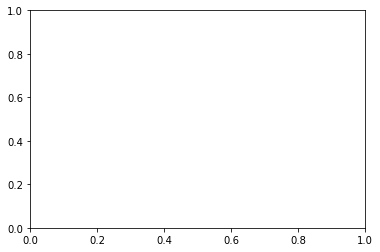

In [151]:
plt.plot(history)

MACCS + TDAF
1377 to 1059 with combined
to 411 with a smaller network
233 smaller network
CM+TDAF
215

In [ ]:
# This loads the data without shuffling or splitting
tasks, datasets, transformers = dc.molnet.load_qm7(
    shard_size=2000,
    featurizer=dc.feat.CoulombMatrix
    (max_atoms=23),
    splitter=None)

# this makes the actual topological datasets
combined_dataset = dc.data.DiskDataset.from_numpy(
    new_X_data, 
    y_data, 
    ids=SMILES_list)

In [3]:
import deepchem as dc
import tensorflow as tf
# This loads the data without shuffling or splitting
tasks, datasets, transformers = dc.molnet.load_qm7(
    shard_size=2000,
    featurizer=dc.feat.CoulombMatrix
    (max_atoms=23),
    splitter=None)

callback = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=3)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1000, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(20, activation='relu'),#
  #tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1)
])

batch_size = 4
epochs = 200

model.compile(
    tf.keras.optimizers.SGD(), 
    loss='mae',
    metrics=["mean_absolute_error"])

#model.compile(
#    loss="mae", 
#    optimizer="adam", 
#    metrics=["mean_absolute_error"],
#    callbacks=[callback])

history=model.fit(
    datasets[0].X, 
    datasets[0].y, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=0.1)

Epoch 1/200
1539/1539 [==============================] - 4s 2ms/step - loss: 0.7803 - mean_absolute_error: 0.7803 - val_loss: 0.9547 - val_mean_absolute_error: 0.9547
Epoch 2/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7712 - mean_absolute_error: 0.7712 - val_loss: 1.0089 - val_mean_absolute_error: 1.0089
Epoch 3/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7651 - mean_absolute_error: 0.7651 - val_loss: 0.9996 - val_mean_absolute_error: 0.9996
Epoch 4/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7609 - mean_absolute_error: 0.7609 - val_loss: 1.0178 - val_mean_absolute_error: 1.0178
Epoch 5/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7582 - mean_absolute_error: 0.7582 - val_loss: 0.9583 - val_mean_absolute_error: 0.9583
Epoch 6/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7555 - mean_absolute_error: 0.7555 - val_loss: 1.0339 - val_mean_absolute_error: 1.033

Epoch 50/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7319 - mean_absolute_error: 0.7319 - val_loss: 0.9790 - val_mean_absolute_error: 0.9790
Epoch 51/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7308 - mean_absolute_error: 0.7308 - val_loss: 0.8942 - val_mean_absolute_error: 0.8942
Epoch 52/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7317 - mean_absolute_error: 0.7317 - val_loss: 0.9793 - val_mean_absolute_error: 0.9793
Epoch 53/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7306 - mean_absolute_error: 0.7306 - val_loss: 1.0109 - val_mean_absolute_error: 1.0109
Epoch 54/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7308 - mean_absolute_error: 0.7308 - val_loss: 1.0062 - val_mean_absolute_error: 1.0062
Epoch 55/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7314 - mean_absolute_error: 0.7314 - val_loss: 0.9872 - val_mean_absolute_error:

Epoch 99/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7266 - mean_absolute_error: 0.7266 - val_loss: 0.9917 - val_mean_absolute_error: 0.9917
Epoch 100/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7279 - mean_absolute_error: 0.7279 - val_loss: 1.0348 - val_mean_absolute_error: 1.0348
Epoch 101/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7272 - mean_absolute_error: 0.7272 - val_loss: 1.0202 - val_mean_absolute_error: 1.0202
Epoch 102/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7268 - mean_absolute_error: 0.7268 - val_loss: 1.0273 - val_mean_absolute_error: 1.0273
Epoch 103/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7257 - mean_absolute_error: 0.7257 - val_loss: 1.0752 - val_mean_absolute_error: 1.0752
Epoch 104/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7270 - mean_absolute_error: 0.7270 - val_loss: 1.0519 - val_mean_absolute_e

1539/1539 [==============================] - 3s 2ms/step - loss: 0.7229 - mean_absolute_error: 0.7229 - val_loss: 0.9639 - val_mean_absolute_error: 0.9639
Epoch 196/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7233 - mean_absolute_error: 0.7233 - val_loss: 0.9671 - val_mean_absolute_error: 0.9671
Epoch 197/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7234 - mean_absolute_error: 0.7234 - val_loss: 0.9915 - val_mean_absolute_error: 0.9915
Epoch 198/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7238 - mean_absolute_error: 0.7238 - val_loss: 1.0372 - val_mean_absolute_error: 1.0372
Epoch 199/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7231 - mean_absolute_error: 0.7231 - val_loss: 0.9570 - val_mean_absolute_error: 0.9570
Epoch 200/200
1539/1539 [==============================] - 3s 2ms/step - loss: 0.7229 - mean_absolute_error: 0.7229 - val_loss: 1.0115 - val_mean_absolute_error: 1.0115


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=3)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(200, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(20, activation='relu'),#
  #tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1)
])

batch_size = 31
epochs = 100

model.compile(
    tf.keras.optimizers.SGD(), 
    loss='mae',
    metrics=["mean_absolute_error"])

#model.compile(
#    loss="mae", 
#    optimizer="adam", 
#    metrics=["mean_absolute_error"],
#    callbacks=[callback])

model.fit(
    combined_dataset.X, 
    combined_dataset.y, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=0.1)

In [10]:
5*40

200